In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from numpy import genfromtxt
import os
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("../../../")
from utils.utils import MyDataset, MyDatasetV2, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from networks.vae import VAE
from networks.vae_v2 import VAE_V2
from networks.ccvae import CCVAE
from networks.utils import EarlyStopper
import argparse
from algorithms.GA.utils import write_firewall_file, erase_firebreaks
from tqdm import tqdm


In [2]:
def top20(tensor):
    shape = tensor.shape
    # Return a tensor with the same size as the input tensor, but with only the top 20 as 1 and the rest as 0
    top20 = torch.topk(tensor.view(-1), 20)[1]
    tensor = torch.zeros_like(tensor.view(-1))
    tensor[top20] = 1
    return tensor.view(shape)

In [3]:
dataset = MyDatasetV2("../../../../data/complete_random/homo_2/")

In [4]:
params = {

}
params["latent_dims"] = 256
params["capacity"] = 128
params["use_gpu"] =  False
params["input_size"] = 20
params["epochs"] = 20
params["sigmoid"] = True
params["lr1"] = 1e-5
params["lr2"] = 1e-5
params["instance"] = "homo_2"
params["not_reduced"] = False
params["variational_beta"] = 0.1
params["distribution_std"] = 0.1
params["latent_portion"] = 0.5
params["alpha"] = 1000

In [5]:
model = CCVAE(params).to("cpu")
model.eval()
model2 = VAE(params).to("cpu")
model2.eval()

VAE(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=6400, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=6400, out_features=256, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6400, bias=True)
  (conv1_): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (criterion): BCELoss()
  (bn1_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1_2): Dropout(p=0.5, inplace=False)
)

In [6]:
# Load weights
# burned_loss_sub20x20_latent=256_capacity=128_20_sigmoid=True_lr1=1e-05_not_reduced=False_variational_beta=0.1_distribution_std=1.0
                                           
model.load_state_dict(torch.load(f'../../../weights/homo_2/CCVAE/sub20x20_latent=256_capacity=128_100_sigmoid=True_T1=100_T2=100_lr1=1e-05_lr2=1e-05_lr3=0.0001_normalize=False_weight_decay=0_not_reduced=False_variational_beta=0.1_distribution_std=0.2_alpha=100000.0.pth', map_location=torch.device('cpu') ))

<All keys matched successfully>

In [7]:
model.training=True

In [219]:
burned_r = []
for x, r in tqdm(dataset):
    _, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
    burned_r.append(r_.item())

100%|██████████| 50000/50000 [08:11<00:00, 101.81it/s]


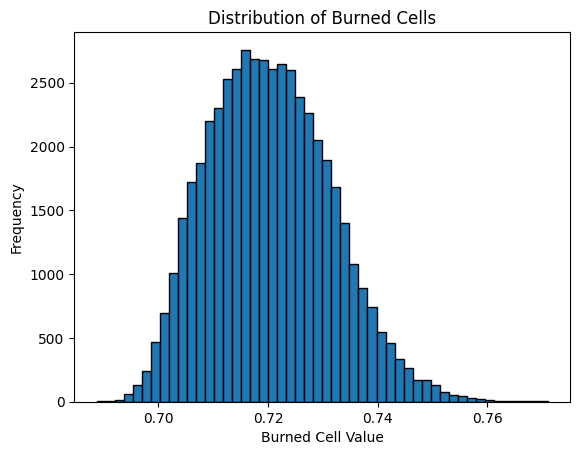

In [222]:
# plotting the distribution of burned_r
plt.hist(burned_r, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

In [195]:
model.training = True

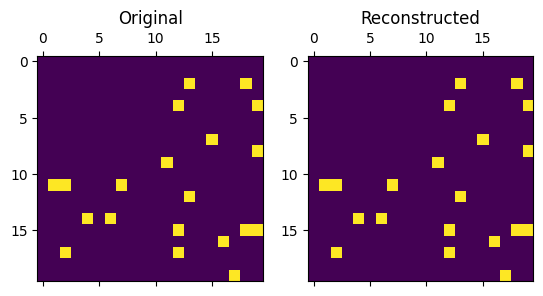

In [196]:
# Sample from the latent space
x, r = dataset[7]
mu, log_sigma = model.encode(x.unsqueeze(0))
sample = model.latent_sample(mu, log_sigma)

# Plot original and reconstructed images
plt.subplot(1, 2, 1)
plt.title('Original')
plt.matshow((x[0] > 0).int(), fignum=False)

plt.subplot(1, 2, 2)
plt.title('Reconstructed')
mat = model.decode(sample)[0][0]
plt.matshow(mat >= 0.5, fignum=False)
plt.show()

In [229]:
model.predict_burned(sample)

tensor([[0.7206]], grad_fn=<SigmoidBackward0>)

In [197]:
x, r = dataset[8]
mu_, log_sigma_ = model.encode(x.unsqueeze(0))

In [198]:
alpha = 0.5
interp = alpha * mu + (1 - alpha) * mu_

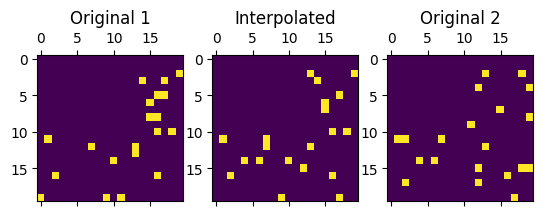

In [204]:
# Plot the original image and the sampled image and interp
plt.subplot(1, 3, 1)
plt.title('Original 1')
plt.matshow((x[0] > 0).int(), fignum=False)

plt.subplot(1, 3, 2)
plt.title('Interpolated')
plt.matshow(top20(model.decode(interp)[0][0]) >= 0.5, fignum=False)

plt.subplot(1, 3, 3)
plt.title('Original 2')
plt.matshow(model.decode(sample)[0][0] >= 0.5, fignum=False)

plt.show()

In [205]:
def calc_fitness(model, embedding, n_sims = 50):
        """
        Calculates the average number of burned cells of embedding's associated
        solution.
        """
        print(embedding.shape)
        solution = model.decode(embedding[0])
        _, indices = torch.topk(solution.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        assert(matrix.sum().item() == 20)
        write_firewall_file(matrix * -1.)
        n_weathers = len([i for i in os.listdir("../../../../data/complete_random/homo_2/Sub20x20/Weathers/") if i.endswith('.csv')])-2
        exec_str = f"../../../algorithms/eval/C2F-W/Cell2Fire/Cell2Fire --input-instance-folder ../../../../data/complete_random/homo_2/Sub20x20/ --output-folder ../../../algorithms/eval/results/ --sim-years 1 --nsims {n_sims}--Fire-Period-Length 1.0 --output-messages --ROS-CV 2.0 --seed 123 --weather random --ignitions --IgnitionRad 4 --sim C --final-grid --nweathers {n_weathers} --FirebreakCells ../../../algorithms/eval/harvested/HarvestedCells.csv"
        os.system(exec_str + " >/dev/null 2>&1")
        reward = 0
        base_directory = f"../../../algorithms/eval/results/Grids/Grids"
        for j in range(1, n_sims+1):
            dir = f"{base_directory}{str(j)}/"
            print(dir)
            files = os.listdir(dir)
            my_data = genfromtxt(dir+files[-1], delimiter=',')
            # Burned cells are counted and turned into negative rewards
            for cell in my_data.flatten():
                if cell == 1:
                    reward-= 1
        erase_firebreaks()
        return 1 + ((reward/n_sims) / 400)

In [172]:
interp.shape

torch.Size([1, 256])

In [218]:
x, r = dataset[15]
mu, log_sigma = model.encode(x.unsqueeze(0))

In [217]:
calc_fitness(model, mu.unsqueeze(0), n_sims=10)

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/


0.7395

In [210]:
calc_fitness(model, sample.unsqueeze(0), n_sims=10)

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/


0.7404999999999999

In [209]:
calc_fitness(model, mu.unsqueeze(0), n_sims=10)

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/


0.7404999999999999

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/
torch.Size([1, 256])
torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grid

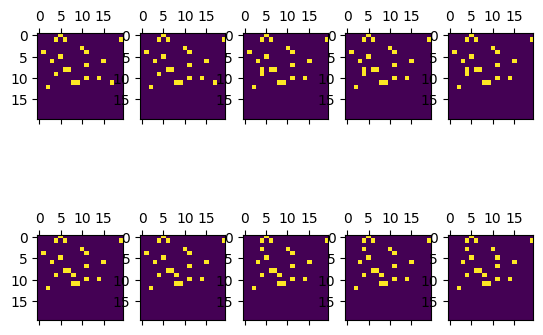

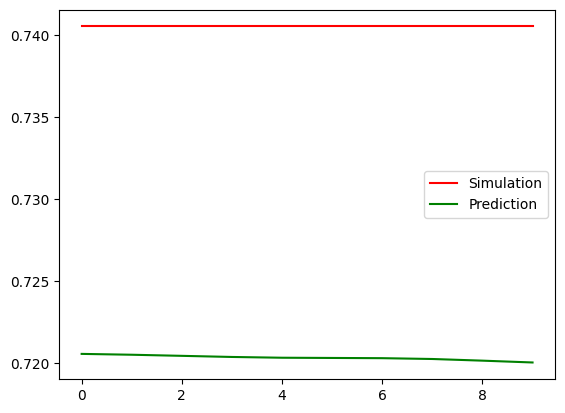

[0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999,
 0.7404999999999999]

In [208]:
mod = model
n = 10
values = []
predictions = []
# make a linear interpolation between mu and mu_
# plot the n images
for alpha_ in range(n):
    alpha = alpha_/n
    interp = alpha * mu + (1 - alpha) * sample
    values.append(calc_fitness(mod, interp.unsqueeze(0), n_sims=10))
    print(interp.shape)
    aa = mod.predict_burned(interp).detach().numpy()
    predictions.append(aa[0][0])
    _, indices = torch.topk(interp.flatten(), 20)
    matrix = torch.zeros((20, 20))
    indices = np.unravel_index(indices, (20, 20))
    matrix[indices] = 1
    plt.subplot(2, n//2, alpha_+1)
    plt.matshow(matrix, fignum=False)
    # plt.show()

plt.show()
# plot the values
plt.plot(values, color = "Red", label = "Simulation")
plt.plot(predictions, color = "Green", label = "Prediction")
plt.legend()
plt.show()
values

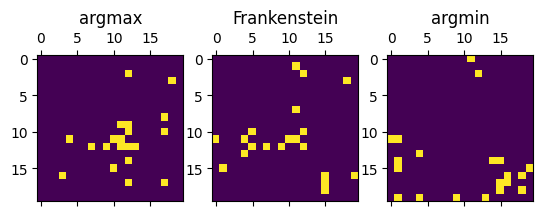

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/
0.79325
torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/
0.

In [271]:
x, r = dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
x_, r_ = dataset[np.argmin(burned_r)]
mu_, log_sigma_ = model.encode(x_.unsqueeze(0))

frankenstein = mu_.clone()
frankenstein[0, 128:] = mu[0, 128:]
reconstrcuted_frankenstein = model.decode(frankenstein)
plt.subplot(1, 3, 1)
plt.title('argmax')
plt.matshow(top20(x[0]), fignum=False)
plt.subplot(1, 3, 3)
plt.title('argmin')
plt.matshow(top20(x_[0]), fignum=False)
plt.subplot(1, 3, 2)
plt.title('Frankenstein')
plt.matshow(top20(reconstrcuted_frankenstein[0][0]), fignum=False)
plt.show()

print(calc_fitness(model, mu.unsqueeze(0), n_sims=10))
print(calc_fitness(model, mu_.unsqueeze(0), n_sims=10))
print(calc_fitness(model, frankenstein.unsqueeze(0), n_sims=10))

In [282]:
mu, log_sigma = model.encode(x.unsqueeze(0))
max_data = torch.tensor(mu[0, 128:]).unsqueeze(0)


/tmp/ipykernel_3016691/2002074556.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_data = torch.tensor(mu[0, 128:]).unsqueeze(0)


In [296]:
x, r = dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
max_data = torch.tensor(mu[0, 128:]).unsqueeze(0)

# Optimize the latent space to maximize predicted performance
latent = max_data
latent_fixed = torch.randn(1, 128) # torch.tensor(mu[0, :128]).unsqueeze(0) #
latent.requires_grad = True
optimizer = torch.optim.Adam([latent], lr=1e-1)

# early_stopper = EarlyStopper(5, 1e-4)
# Freeze the model
model.eval()
model.training = False
losses = []
fitnesses = []
latents = []
for i in range(100):
    full_latent = torch.cat([latent_fixed, latent], dim=1)
    latents.append(full_latent)
    optimizer.zero_grad()
    loss = -model.predict_burned(full_latent)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    fitnesses.append(calc_fitness(model, full_latent.unsqueeze(0), n_sims=10))
    # if early_stopper(loss.item()):
    #     break

/tmp/ipykernel_3016691/95362487.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_data = torch.tensor(mu[0, 128:]).unsqueeze(0)


torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/
torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/
torch.Size

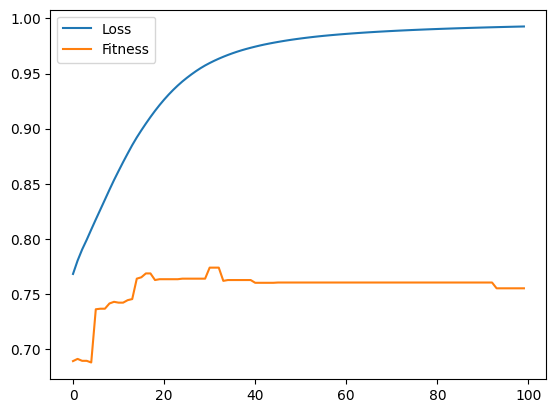

In [298]:
losses = np.array(losses)
plt.plot((-1)*losses, label='Loss')
plt.plot(fitnesses, label='Fitness')
plt.legend()
plt.show()

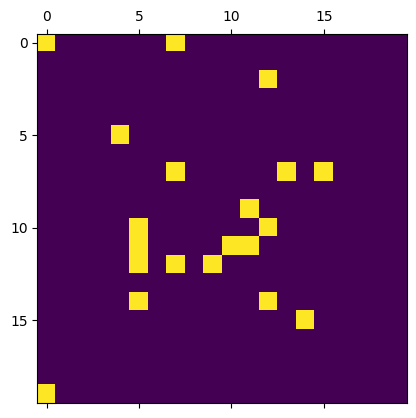

In [303]:
mat = model.decode(latents[-1])[0][0]
plt.matshow(top20(mat), fignum=False)
plt.show()

In [291]:
np.max(fitnesses)

0.8195

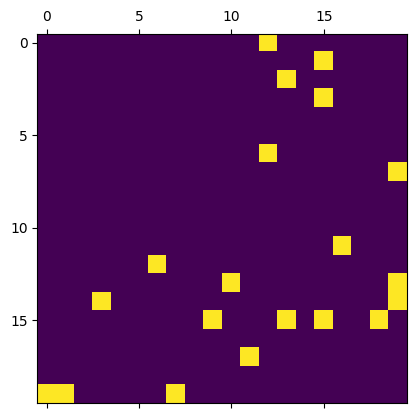

In [237]:
# Plot the optimized latent space
plt.matshow(top20(model.decode(latent)[0][0]), fignum=False)
plt.show()

In [243]:
calc_fitness(mod, latent.unsqueeze(0), n_sims=10)

torch.Size([1, 1, 256])
../../../algorithms/eval/results/Grids/Grids1/
../../../algorithms/eval/results/Grids/Grids2/
../../../algorithms/eval/results/Grids/Grids3/
../../../algorithms/eval/results/Grids/Grids4/
../../../algorithms/eval/results/Grids/Grids5/
../../../algorithms/eval/results/Grids/Grids6/
../../../algorithms/eval/results/Grids/Grids7/
../../../algorithms/eval/results/Grids/Grids8/
../../../algorithms/eval/results/Grids/Grids9/
../../../algorithms/eval/results/Grids/Grids10/


0.782

In [ ]:
# Plot latent space data and the optimized latent space data using dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X = torch.cat(latents, dim=0).detach().numpy()
X_embedded = tsne.fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.show()
